In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import Aer, execute
from qiskit.circuit import Parameter

G = nx.Graph()
G.add_nodes_from([0, 1, 2, 3])
G.add_edges_from([(0, 1), (1, 2), (2, 3), (3, 0)])
nx.draw(G, with_labels=True, alpha=0.8, node_size=500)

In [ ]:
def maxcut_obj(x, G):
    obj = 0
    for i, j in G.edges():
        if x[i] != x[j]:
            obj -= 1
    return obj

def compute_expectation(counts, G):
    avg = 0
    sum_count = 0

    for bitstr, count in counts.items():
        obj = maxcut_obj(bitstr[::-1], G)
        avg += obj * count
        sum_count += count

    return avg/sum_count

def create_qaoa_circ(G, theta):
    nqubits = len(G.nodes())
    p = len(theta)//2 # num layers
    qc = QuantumCircuit(nqubits)

    beta = theta[:p]
    gamma = theta[p:]

    # |v0>
    for i in range(0, nqubits):
        qc.h(i)

    for irep in range(0, p):
        # Hp
        for pair in list(G.edges()):
            qc.rzz(2 * gamma[irep], pair[0], pair[1])

        # Hm
        for i in range (0, nqubits):
            qc.rx(2 * beta[irep], i)

    qc.measure_all()

    return qc

def get_expectation(G, shots=512):
    backend = Aer.get_backend('qasm_simulator')
    backend.shots = shots

    def execute_circ(theta):
        qc = create_qaoa_circ(G, theta)
        counts = backend.run(qc, seed_simulator=10,
                             nshots=512).result().get_counts()
        return compute_expectation(counts, G)

    return execute_circ

In [6]:
from scipy.optimize import minimize

expectation = get_expectation(G)

num_layers = 2
res = minimize(expectation, [1.0, 1.0] * num_layers, method = "COBYLA")
res

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -3.92578125
       x: [ 2.085e+00  2.175e+00  1.002e+00  1.057e+00]
    nfev: 40
   maxcv: 0.0

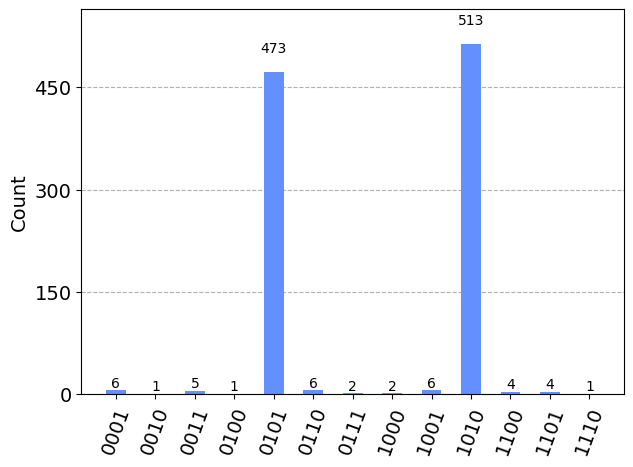

In [5]:
from qiskit.visualization import plot_histogram

backend = Aer.get_backend('aer_simulator')
backend.shots = 512

qc_res = create_qaoa_circ(G, res.x)

counts = backend.run(qc_res, seed_simulator=10).result().get_counts()
plot_histogram(counts)